In [358]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive


Mounted at /content/gdrive


In [359]:

%matplotlib inline
import torch 
from torch import nn
import matplotlib.pyplot as plt
from torch.utils import data
import random

In [360]:
'''Data used to train the model'''
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1 #tensor of size [2000, 40, 1] representing all the input variables x
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a) #tensor of size [2000, 40, 1] representing all the output of the functions f(x)

'''Validation data for the evaluation of the model'''
num_f, num_pts = 6, 40 # the number of different functions f that we will generate, and number of x values that we will use to generate each fa
x_validation = torch.zeros(num_f, num_pts, 1)
for k in range(num_f):
    x_validation[k,:,0] = torch.linspace(-2, 2, num_pts)
x_validation += torch.rand_like(x_validation)*0.1 #tensor of size [num_f, num_pts, 1] representing all the input variables x
a = -2 + 4*torch.rand(num_f).view(-1,1).repeat(1, num_pts).unsqueeze(2)
y_validation = a*torch.sin(x_validation+a) #tensor of size [num_f, num_pts, 1] representing all the output of the functions f(x)

In [361]:
''' Task 1: training dataset and dataloader '''
dataset = data.TensorDataset(x, y) #setting dataset with x and y using TensorDataset object
batch_size = 128 #setting the batch size as a power of 2, the smallest the value the most accurate the prediction is
train_iter = data.DataLoader(dataset, batch_size, shuffle=True) #using DataLoader object

In [362]:
''' Task 2: Defining Encoder and Decoder'''
class Encoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Encoder, self).__init__()

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hidden = num_hidden

        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_outputs)
        
        self.ReLU = nn.ReLU()
        
    def forward(self, xc_yc, x, Nc, num_x):
        xc_yc = xc_yc.view(-1, Nc, self.num_inputs) #validating the size of the input xc,yc
        out = self.Linear1(xc_yc)
        out = self.ReLU(out)
        out = self.Linear2(out)
        #taking the average of the rcs then cloning them 40 times in dimension 1 to fit the input x
        rc = torch.mean(out, 1, True)
        rC = rc.repeat(1,num_x,1)
        #concatenating input x with averaged rC
        dec_inp = torch.cat((rC, x),2)
        return dec_inp
    
class Decoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Decoder, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hidden = num_hidden

        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_outputs)
        
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, x.size(1), self.num_inputs)
        out = self.Linear1(x)
        out = self.ReLU(out)
        out = self.Linear2(out)
        return out
  
#function to initialize weights and bias for each MLP 
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.normal_(m.weight, std=0.01) #each weight sampled from a Gaussian with mean 0 and std 0.01
        torch.nn.init.zeros_(m.bias) #bias initialized to 0

In [363]:
''' Task 3: create and initialize models + optimizer and loss for model '''
rdim = 10 #set feature representation size

'''initializing MLPs + model parameters'''
inp_enc, hdim_enc, out_enc = 2, 128, rdim
inp_dec, hdim_dec, out_dec = rdim+1, 128, 1

enc = Encoder(inp_enc, hdim_enc, out_enc)
enc.apply(init_weights)
dec = Decoder(inp_dec, hdim_dec, out_dec)    
dec.apply(init_weights)


'''defining the optimization algorith'''
lr, wd = 0.001, 0  #setting learning rate and weigth decay for the optimizer
parameters = list(enc.parameters()) + list(dec.parameters()) #creating a list containing both parameters of the encoder and decoder
#optimizer = torch.optim.SGD(parameters, lr = lr, weight_decay = wd)
optimizer = torch.optim.Adam(parameters, lr = lr)

'''defining loss function'''
loss = nn.MSELoss()
#loss = nn.L1Loss()

In [364]:
''' Task 4: Model training'''
epochs = 1000

loss_visualization = []
e = []

print('Training starts...\n')

for epoch in range(epochs):
    
    for x,y in train_iter:
        
        num_x = x.size(1)

        #Nc = random.randint(2,num_x+1)
        Nc = 38
        
        #creating context data (xc,yc)
        xc_yc = torch.zeros(x.size(0), Nc, 2)
        rand = torch.tensor(random.sample(range(0, num_x), Nc))
        xc_yc[:, :, 0] = x[:,rand,0]
        xc_yc[:, :, 1] = y[:,rand,0]
        
        #training encoder and decoder jointly
        enc_out = enc(xc_yc, x, Nc, num_x)
        y_pred = dec(enc_out)

        optimizer.zero_grad()
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()
        
    e.append(epoch)
    loss_visualization.append(l)
    print(f'epoch {epoch + 1}, loss {l:f}')
    
print('\n Training ends.')

Training starts...

epoch 1, loss 0.481724
epoch 2, loss 0.435705
epoch 3, loss 0.352518
epoch 4, loss 0.390160
epoch 5, loss 0.323656
epoch 6, loss 0.382584
epoch 7, loss 0.300193
epoch 8, loss 0.281608
epoch 9, loss 0.286211
epoch 10, loss 0.258495
epoch 11, loss 0.208071
epoch 12, loss 0.181151
epoch 13, loss 0.211176
epoch 14, loss 0.197950
epoch 15, loss 0.189255
epoch 16, loss 0.185149
epoch 17, loss 0.179871
epoch 18, loss 0.183115
epoch 19, loss 0.194678
epoch 20, loss 0.139101
epoch 21, loss 0.145594
epoch 22, loss 0.096623
epoch 23, loss 0.076669
epoch 24, loss 0.076378
epoch 25, loss 0.076411
epoch 26, loss 0.057151
epoch 27, loss 0.060251
epoch 28, loss 0.057566
epoch 29, loss 0.064315
epoch 30, loss 0.050110
epoch 31, loss 0.043775
epoch 32, loss 0.041929
epoch 33, loss 0.047137
epoch 34, loss 0.048919
epoch 35, loss 0.044974
epoch 36, loss 0.044169
epoch 37, loss 0.038363
epoch 38, loss 0.046008
epoch 39, loss 0.041775
epoch 40, loss 0.033888
epoch 41, loss 0.036660
epoch

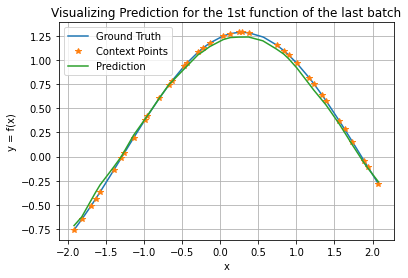

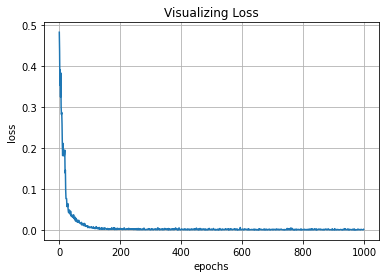

In [365]:
#plotting the first function of the last trained batch
plt.figure()
plt.plot(x[0,:,0], y[0,:,0])
plt.plot(xc_yc[0,:,0], xc_yc[0,:,1], '*')
plt.plot(x[0,:,0], y_pred[0,:,0].detach());
plt.title("Visualizing Prediction for the 1st function of the last batch")
plt.grid()
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend(['Ground Truth', 'Context Points', 'Prediction'])

#plotting the loss
plt.figure()
plt.title("Visualizing Loss")
plt.grid()
plt.plot(e, loss_visualization)
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()


Ratio for of the correct prediction of the prediction considering a margin of error:  1.0


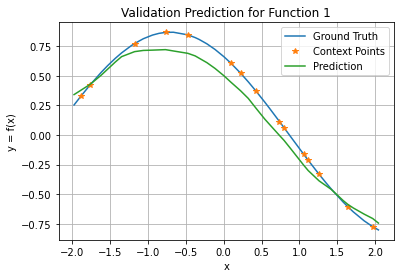

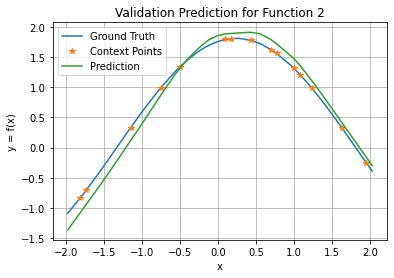

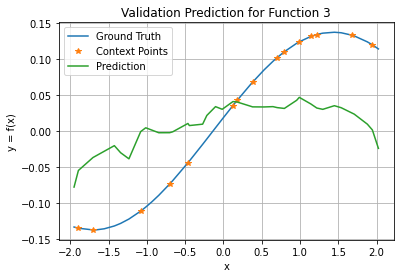

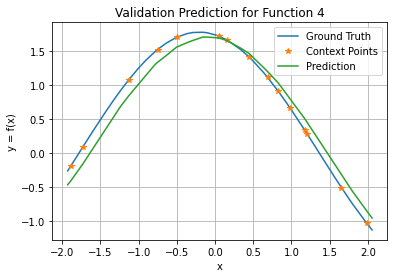

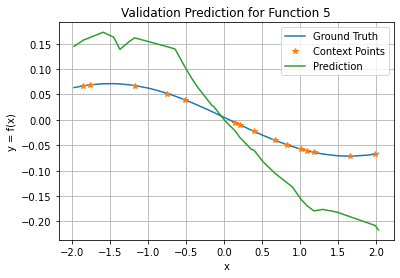

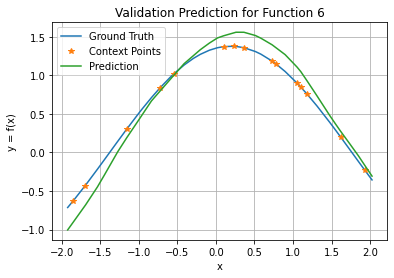

In [366]:
''' Task 5: Validation Data'''
#feeding the created data for the validation into the model and computing the accuracy
Nc = random.randint(2,num_pts+1)
num_x = x_validation.size(1)
xc_yc_val = torch.zeros(x_validation.size(0), Nc, 2)
rand = torch.tensor(random.sample(range(0, num_x), Nc))
xc_yc_val[:, :, 0] = x_validation[:,rand,0]
xc_yc_val[:, :, 1] = y_validation[:,rand,0]

num_x = x_validation.size(1)
enc_out = enc(xc_yc_val, x_validation, xc_yc_val.size(1), num_x)
pred_validation = dec(enc_out)

#setting the maximal squared error the prediction can have and computing the ratio of the correct predictions over all predictions
max_margin_of_error = ((pred_validation - y_validation) ** 2 < 0.1)
correct = max_margin_of_error.eq(True).sum().item()
incorrect = max_margin_of_error.eq(False).sum().item()
ratio = correct/(correct + incorrect)
print("Ratio for of the correct prediction of the prediction considering a margin of error: ", round(ratio, 2))

#plotting all 5 validation functions
for j in range(num_f):
    plt.figure()
    plt.plot(x_validation[j,:,0], y_validation[j,:,0])
    plt.plot(xc_yc_val[j,:,0], xc_yc_val[j,:,1], '*')
    plt.plot(x_validation[j,:,0], pred_validation[j,:,0].detach());
    plt.title(f'Validation Prediction for Function {j+1}')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y = f(x)')
    plt.legend(['Ground Truth', 'Context Points', 'Prediction'])

plt.show()

## Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 

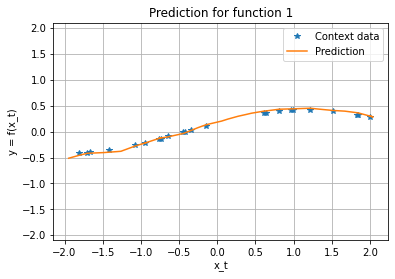

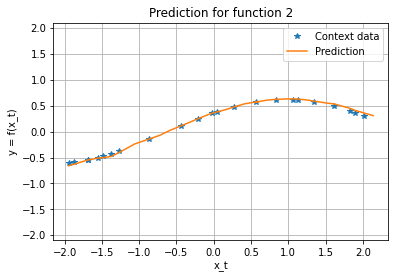

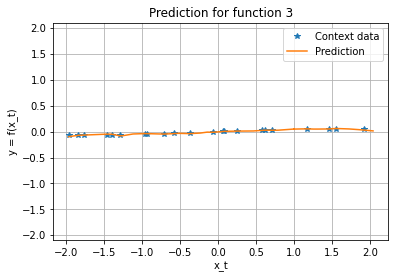

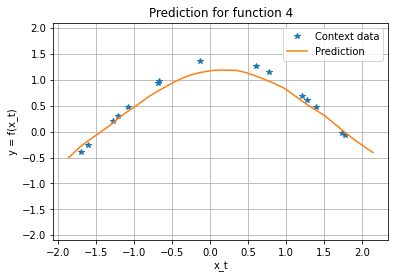

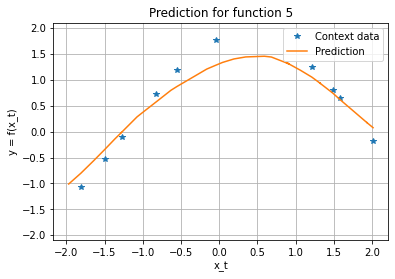

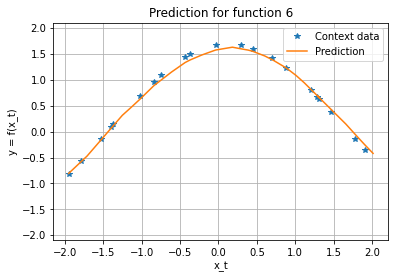

In [367]:
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))

#for each function the context data is fed into the model to give the prediction
for i in range(1,7): #i=1,..6
  name= 'function_num_{}'.format(i)
  x_c=test_data[name]['context_pairs'][0]
  y_c=test_data[name]['context_pairs'][1]
  x_t =test_data[name]['x']

  #running the model
  xc_yc = torch.cat((x_c,y_c),2)
  enc_out = enc(xc_yc, x_t, xc_yc.size(1), x_t.size(1))
  prediction = dec(enc_out)

  #plot of the function
  plt.figure()
  plt.ylim(-2.1, 2.1)
  plt.plot(x_c[0, :,:], y_c[0,:,:], '*')
  plt.plot(x_t[0,:,:], prediction[0,:,0].detach());
  plt.title(f'Prediction for function {i}')
  plt.grid();
  plt.xlabel('x_t');
  plt.ylabel('y = f(x_t)');
  plt.legend(['Context data', 'Prediction'])

plt.show()